# Chapter 10 - Portfolio theory introduction
---

In [1]:
# Preamble
import pandas as pd
import numpy as np
import os # To set our working folder
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen as uReq
import urllib.error as uErr
import re
import tenacity
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mticker
import seaborn as sns
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
from linearmodels.panel import PanelOLS
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate
from IPython.display import display, Math

if os.name=='nt':
    import xlwings as xw


@tenacity.retry(wait=tenacity.wait_exponential(multiplier=1, min=4, max=64), stop=tenacity.stop_after_attempt(5))
def get_that_page(url):
    try:
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        uClient = uReq(req)
        print('Success')
    except Exception:
        print('Trying again.')
    return uClient


def get_nzx(url):
    uClient = get_that_page(url)
    soup = BeautifulSoup(uClient, 'lxml')
    table = soup.find('table', class_='instruments-table')
    table_headers =[]
    for tx in soup.find_all('th'):
        table_headers.append(tx.get('id'))

    filler = ['unknown', 'pct']
    data = []
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        #print(cols)
        if len(cols)>0:
            data.append(cols)
    df = pd.DataFrame(data, columns=[x if x!=None else filler.pop() for x in table_headers])
    lyst = ['price', 'volume', 'value', 'outstanding_capitalisation', 'market_capitalisation', 'pct', 'trade_count']
    df[lyst] = df[lyst].replace({'\$': '', ',': ''}, regex=True).apply(pd.to_numeric,  errors='coerce')
    df['green_bond']= df['green_bond'].map({'false': 0, 'true': 1})
    df = df[~df['company'].str.contains('Smartshares')]
    df['code'] = df['code']+".NZ"
    nzx = df['code'].to_list()

    return(df[df['market_capitalisation']>0], nzx)


def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left =  lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)


def nice_print(df, k=1, name=""):
    if isinstance(df, pd.DataFrame):
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))
    elif isinstance(df, pd.Series):
        df.name= name
        df=df.to_frame()
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))

---

**Get NZX tickers from its web-site**


In [2]:
dfm, nzx  = get_nzx('https://www.nzx.com/markets/NZSX')
nzx+=['^NZ50']
print(dfm.head(3))
print(nzx)

Success
     code                                           company  price  \
0  AFI.NZ  Australian Foundation Investment Company Limited   8.81   
1  ANZ.NZ   Australia and New Zealand Banking Group Limited  27.90   
3  MHJ.NZ                Michael Hill International Limited   1.14   

             change  volume      value  outstanding_capitalisation       pct  \
0  -$0.120 / -1.34%    2988   26462.27                 10835474556 -1.343785   
1  -$0.140 / -0.50%   15365  429115.49                 77955506455 -0.499287   
3  -$0.010 / -0.87%   47241   54170.63                   442645326 -0.869565   

    unknown  green_bond  trade_count currency_code  market_capitalisation  
0  CLOSEEND           0           14           NZD           1.116054e+08  
1                     0          245           NZD           6.938040e+08  
3                     0           39           NZD           9.477036e+07  
['AFI.NZ', 'ANZ.NZ', 'DOW.NZ', 'MHJ.NZ', 'WBC.NZ', 'AKL.NZ', 'DGC.NZ', 'VSL.NZ', 'VNT.

**Obtain returns:**

In [3]:
def returns(nzx, start, end):
    df_close = yf.download(nzx, start, end, progress=True, interval="1mo")['Adj Close']
    df_close.dropna(how = 'all', inplace=True, axis = 1)
    df_close.sort_index(inplace=True)
    df_close.index = pd.to_datetime(df_close.index, format ='%Y-%m-%d')
    df_close.columns = [re.sub(r'.NZ$|\^', "", x) for x in list(df_close)]
    return list(df_close), df_close.resample('M').last()

nzx_set, df_close = returns(nzx, '2011-10-01', '2022-04-30')

[*********************100%***********************]  152 of 152 completed

10 Failed downloads:
- NTLOB.NZ: No data found, symbol may be delisted
- FCT.NZ: No data found for this date range, symbol may be delisted
- BIT.NZ: No data found for this date range, symbol may be delisted
- AKL.NZ: No data found, symbol may be delisted
- MLNWE.NZ: No data found, symbol may be delisted
- PLP.NZ: No data found for this date range, symbol may be delisted
- JPG.NZ: No data found for this date range, symbol may be delisted
- CO2.NZ: No data found for this date range, symbol may be delisted
- KFLWG.NZ: No data found, symbol may be delisted
- BIF.NZ: No data found for this date range, symbol may be delisted


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

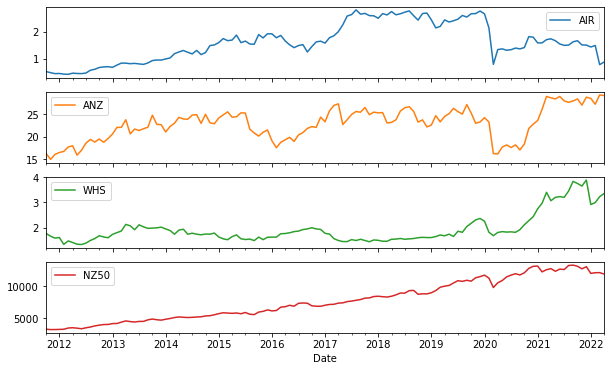

In [4]:
stocks_list = ["AIR", "ANZ", 'WHS', 'NZ50'] #, 'BGP', 'FPH', 'RYM', 'AIA', 'THL', 'NZ50']  
data = df_close[stocks_list]
data.plot(figsize=(10, 6), subplots=True)

---

### Stocks Statistics 

**Calculate monthly returns using the difference of logs**

In [5]:
monthly_ret = np.log(data).diff().dropna()
monthly_ret.head(3)


,AIR,ANZ,WHS,NZ50
Date,,,,
2011-11-30,-0.079249,-0.085788,-0.060805,-0.018887
2011-12-31,-0.074901,0.070919,-0.048520,0.001375
2012-01-31,0.011050,0.026979,0.013245,0.006541


**Geometric mean**

$$\begin{aligned} \bar{R}_{G i} &=\sqrt[T]{\left(1+R_{i 1}\right) \times\left(1+R_{i 2}\right) \times \ldots \times\left(1+R_{i, T-1}\right) \times\left(1+R_{i T}\right)}-1 \\ &=\sqrt[T]{\prod_{t=1}^{T}\left(1+R_{i t}\right)-1} \end{aligned}$$

╒═════════════════════╤══════════╤═════════╤══════════╤═════════╕
│ Date                │      AIR │     ANZ │      WHS │    NZ50 │
╞═════════════════════╪══════════╪═════════╪══════════╪═════════╡
│ 2021-12-31 00:00:00 │  -0.3306 │  6.3304 │   6.3393 │  2.5978 │
├─────────────────────┼──────────┼─────────┼──────────┼─────────┤
│ 2022-01-31 00:00:00 │  -4.7466 │ -0.9543 │ -28.7682 │ -8.3023 │
├─────────────────────┼──────────┼─────────┼──────────┼─────────┤
│ 2022-02-28 00:00:00 │   3.7483 │ -4.6259 │   2.6317 │  0.8410 │
├─────────────────────┼──────────┼─────────┼──────────┼─────────┤
│ 2022-03-31 00:00:00 │ -63.7449 │  7.2954 │   7.5035 │  0.1122 │
├─────────────────────┼──────────┼─────────┼──────────┼─────────┤
│ 2022-04-30 00:00:00 │  11.3155 │ -0.4679 │   3.8409 │ -1.8835 │
╘═════════════════════╧══════════╧═════════╧══════════╧═════════╛


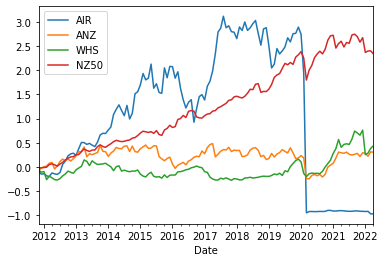

In [6]:
monthly_ret.add(1).cumprod().sub(1).plot() # monthly_ret.cumsum().apply(np.exp).plot()

nice_print(monthly_ret.tail(5), k=100, name="")

In [7]:
def prelim_tables(df):
    df = df.copy()
    df['year'] = df.index.year.astype(int)
    df.set_index('year', append=True, inplace=True)
    print('Returns by year')
    nice_print(df.add(1).groupby('year').prod().sub(1), 100)
    
prelim_tables(monthly_ret) 

Returns by year
╒════════╤══════════╤══════════╤══════════╤═════════╕
│   year │      AIR │      ANZ │      WHS │    NZ50 │
╞════════╪══════════╪══════════╪══════════╪═════════╡
│   2011 │ -14.8215 │  -2.0953 │ -10.6374 │ -1.7537 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2012 │  50.9012 │  19.6986 │  -2.4438 │ 23.5295 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2013 │  31.6247 │  12.3514 │  23.6135 │ 15.8919 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2014 │  51.0317 │  -0.7758 │ -13.0266 │ 17.3026 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2015 │  20.5282 │  -7.8447 │ -11.3530 │ 12.9256 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2016 │ -18.9719 │  10.6086 │  18.6205 │  7.9612 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2017 │  51.7388 │   1.2943 │ -22.9155 │ 21.7938 │
├────────┼──────────┼──────────┼──────────┼─────────┤
│   2018 │   2.4678 │ -14.4121 │   6.0473 │  4.4771 │
├────────┼──

In [8]:
# Mean Returns
mean_ret = monthly_ret.mean()
mean_ret.name = 'Mean Monthly Return'
print(mean_ret*100)

AIR     0.397808
ANZ     0.461396
WHS     0.507586
NZ50    1.009109
Name: Mean Monthly Return, dtype: float64


In [9]:
# Sigma
sigma    = monthly_ret.std()
sigma.name = 'Sigma'
print(sigma)

AIR     0.138227
ANZ     0.067942
WHS     0.064662
NZ50    0.030847
Name: Sigma, dtype: float64


AIR     0.003978
ANZ     0.004614
WHS     0.005076
NZ50    0.010091
Name: Mean Monthly Return, dtype: float64


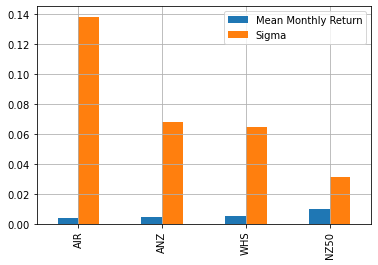

In [10]:
mean_ret.to_frame().join(sigma.to_frame()).sort_values(by=['Mean Monthly Return']).plot(kind='bar', grid=True)
print(mean_ret)


#### COMPUTING COVARIANCE AND CORRELATION ####

In [11]:
# Calculate excess returns
print('Monthly returns')
nice_print(monthly_ret.head(2))
print('Mean returns')
nice_print(mean_ret)

excess_ret = (monthly_ret - mean_ret)

print('Excess returns')
nice_print(excess_ret.head(2))

print('Excess returns using .sub()')
excess_ret = monthly_ret.sub(mean_ret)
nice_print(excess_ret.head(2))

Monthly returns
╒═════════════════════╤═════════╤═════════╤═════════╤═════════╕
│ Date                │     AIR │     ANZ │     WHS │    NZ50 │
╞═════════════════════╪═════════╪═════════╪═════════╪═════════╡
│ 2011-11-30 00:00:00 │ -0.0792 │ -0.0858 │ -0.0608 │ -0.0189 │
├─────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ 2011-12-31 00:00:00 │ -0.0749 │  0.0709 │ -0.0485 │  0.0014 │
╘═════════════════════╧═════════╧═════════╧═════════╧═════════╛
Mean returns
╒══════╤════════╕
│      │        │
╞══════╪════════╡
│ AIR  │ 0.0040 │
├──────┼────────┤
│ ANZ  │ 0.0046 │
├──────┼────────┤
│ WHS  │ 0.0051 │
├──────┼────────┤
│ NZ50 │ 0.0101 │
╘══════╧════════╛
Excess returns
╒═════════════════════╤═════════╤═════════╤═════════╤═════════╕
│ Date                │     AIR │     ANZ │     WHS │    NZ50 │
╞═════════════════════╪═════════╪═════════╪═════════╪═════════╡
│ 2011-11-30 00:00:00 │ -0.0832 │ -0.0904 │ -0.0659 │ -0.0290 │
├─────────────────────┼─────────┼─────────┼─────────┼─

**Using Excel to check**

In [12]:
wb = xw.Book()  
sheet = wb.sheets['Sheet1']
sheet.range('A1').value = monthly_ret
sheet.range('G1').value = excess_ret

**Covariance**

$$
\frac{1}{N} \sum_{t=1}^{N}\left(r_{i t}-\bar{r}_{i}\right)\left(r_{j t}-\bar{r}_{j}\right)
$$


In [13]:
# Covariance 
(excess_ret['AIR']*excess_ret['ANZ']).mean()

0.003312046510171406

$$
\frac{1}{N-1} \sum_{t=1}^{N}\left(r_{i t}-\bar{r}_{i}\right)\left(r_{j t}-\bar{r}_{j}\right)
$$

In [14]:
N = len(excess_ret)
(excess_ret['AIR']*excess_ret['ANZ']).mean()*N/(N-1)

0.003338542882252777

In [15]:
cov_mat  = monthly_ret.cov()
display(Math(r'\rho_{ij}\sigma_i\sigma_j'))
nice_print(cov_mat, 1, 'Covariances')

<IPython.core.display.Math object>

╒══════╤════════╤════════╤════════╤════════╕
│      │    AIR │    ANZ │    WHS │   NZ50 │
╞══════╪════════╪════════╪════════╪════════╡
│ AIR  │ 0.0191 │ 0.0033 │ 0.0017 │ 0.0021 │
├──────┼────────┼────────┼────────┼────────┤
│ ANZ  │ 0.0033 │ 0.0046 │ 0.0009 │ 0.0010 │
├──────┼────────┼────────┼────────┼────────┤
│ WHS  │ 0.0017 │ 0.0009 │ 0.0042 │ 0.0007 │
├──────┼────────┼────────┼────────┼────────┤
│ NZ50 │ 0.0021 │ 0.0010 │ 0.0007 │ 0.0010 │
╘══════╧════════╧════════╧════════╧════════╛


<IPython.core.display.Math object>

╒══════╤════════╤════════╤════════╤════════╕
│      │    AIR │    ANZ │    WHS │   NZ50 │
╞══════╪════════╪════════╪════════╪════════╡
│ AIR  │ 1.0000 │ 0.3555 │ 0.1875 │ 0.5017 │
├──────┼────────┼────────┼────────┼────────┤
│ ANZ  │ 0.3555 │ 1.0000 │ 0.2104 │ 0.4788 │
├──────┼────────┼────────┼────────┼────────┤
│ WHS  │ 0.1875 │ 0.2104 │ 1.0000 │ 0.3719 │
├──────┼────────┼────────┼────────┼────────┤
│ NZ50 │ 0.5017 │ 0.4788 │ 0.3719 │ 1.0000 │
╘══════╧════════╧════════╧════════╧════════╛


<AxesSubplot:>

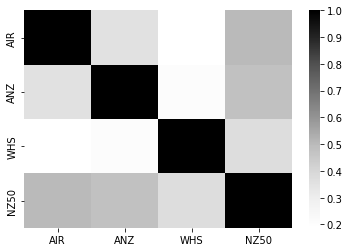

In [16]:
# Correlation Matrix
display(Math(r'\rho_{ij}'))
corr_mat = monthly_ret.corr()
nice_print(corr_mat, 1)
sns.heatmap(corr_mat, cmap="Greys")

In [17]:
# Regression
results = smf.ols('AIR ~ 1 + ANZ', data=monthly_ret).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    AIR   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     17.94
Date:                Thu, 12 May 2022   Prob (F-statistic):           4.41e-05
Time:                        14:58:18   Log-Likelihood:                 79.563
No. Observations:                 126   AIC:                            -155.1
Df Residuals:                     124   BIC:                            -149.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006      0.012      0.055      0.9

In [18]:
#Scatter Plot

def scattplot(X, Y, monthly_ret):
    results = smf.ols(Y + ' ~ 1 + ' + X, data=monthly_ret).fit()
    
    fig = plt.figure(figsize=(7,6))
    ax = sns.regplot(x=X, y=Y, data=monthly_ret, scatter_kws={'s':5})
    
    set_xmargin(ax, left=0, right=0)
    
    # Titles and axes names
    ax.set_title(r'Monthly Returns')
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    plt.grid(linestyle="dotted", color='grey')
    
    # Equation
    plusmin = '-' if results.params.Intercept<0 else '+'
    equation = f'${{{Y}}}$ =  {results.params[1]:.3f} ${{{X}}}$ {plusmin} {abs(results.params.Intercept):.3f}'
    ax.text(y = monthly_ret[Y].max(), x = monthly_ret[X].min(), s = equation)
    plt.show()
    print(results.summary())
    return

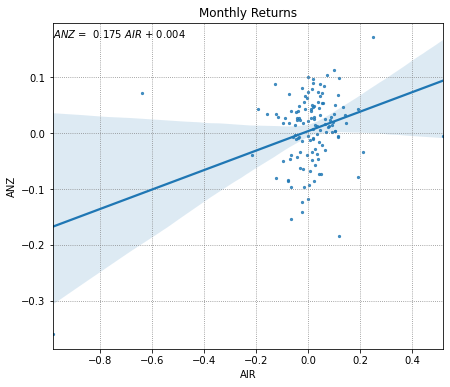

                            OLS Regression Results                            
Dep. Variable:                    ANZ   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     17.94
Date:                Thu, 12 May 2022   Prob (F-statistic):           4.41e-05
Time:                        14:58:19   Log-Likelihood:                 169.05
No. Observations:                 126   AIC:                            -334.1
Df Residuals:                     124   BIC:                            -328.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0039      0.006      0.690      0.4

In [19]:
scattplot('AIR','ANZ', monthly_ret)

**Return on an equally-weigthed portfolio plotted agains the NZ50**

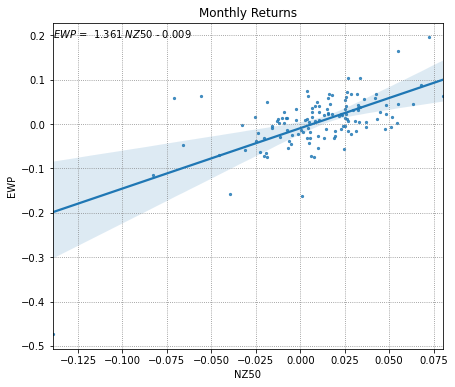

                            OLS Regression Results                            
Dep. Variable:                    EWP   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     82.19
Date:                Thu, 12 May 2022   Prob (F-statistic):           2.28e-15
Time:                        14:58:19   Log-Likelihood:                 195.31
No. Observations:                 126   AIC:                            -386.6
Df Residuals:                     124   BIC:                            -381.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0092      0.005     -1.890      0.0

In [20]:
# Return on an equally weigthed portfolio
scattplot('NZ50','EWP', monthly_ret.assign(EWP = monthly_ret[[x for x in list(monthly_ret) if x!="NZ50"]].mean(axis=1)))

### Building a portfolio of two stocks
---

[*********************100%***********************]  3 of 3 completed


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

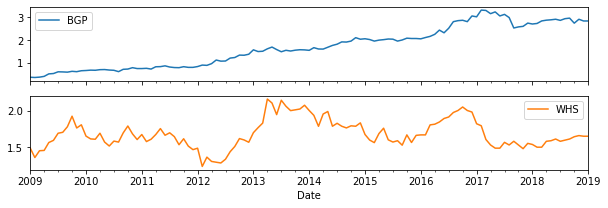

In [21]:
nzx_set, df_close = returns(['BGP.NZ','WHS.NZ']+['^NZ50'], '2009-01-01', '2019-01-01')

stocks_list = ['BGP', 'WHS' ]  
data = df_close[stocks_list]
data.plot(figsize=(10, 3), subplots=True)

In [22]:
monthly_ret = np.log(data).diff().dropna()
mean_ret = monthly_ret.mean()
mean_ret.name = 'Mean Monthly Return'
sigma    = monthly_ret.std()
sigma.name = 'Sigma'

In [23]:
nice_print(mean_ret.to_frame().join(sigma), 1, 'Returns')
cov_mat  = monthly_ret.cov()

print('\nCorrelations')
display(Math(r'\rho_{ij}'))
corr_mat = monthly_ret.corr()
nice_print(corr_mat, 1)

print('\nCovariances:')
display(Math(r'\rho_{ij}\sigma_i\sigma_j'))
nice_print(cov_mat, 1)

╒═════╤═══════════════════════╤═════════╕
│     │   Mean Monthly Return │   Sigma │
╞═════╪═══════════════════════╪═════════╡
│ BGP │                0.0172 │  0.0555 │
├─────┼───────────────────────┼─────────┤
│ WHS │                0.0009 │  0.0532 │
╘═════╧═══════════════════════╧═════════╛

Correlations


<IPython.core.display.Math object>

╒═════╤════════╤════════╕
│     │    BGP │    WHS │
╞═════╪════════╪════════╡
│ BGP │ 1.0000 │ 0.2109 │
├─────┼────────┼────────┤
│ WHS │ 0.2109 │ 1.0000 │
╘═════╧════════╧════════╛

Covariances:


<IPython.core.display.Math object>

╒═════╤════════╤════════╕
│     │    BGP │    WHS │
╞═════╪════════╪════════╡
│ BGP │ 0.0031 │ 0.0006 │
├─────┼────────┼────────┤
│ WHS │ 0.0006 │ 0.0028 │
╘═════╧════════╧════════╛


In [24]:
# Set proportions
Xa = 0.5
Xb = 1 - Xa
prop = pd.DataFrame(data = [Xa, Xb], columns = ['Weights'],  index=['BGP','WHS']).T
nice_print(prop)

╒═════════╤════════╤════════╕
│         │    BGP │    WHS │
╞═════════╪════════╪════════╡
│ Weights │ 0.5000 │ 0.5000 │
╘═════════╧════════╧════════╛


In [25]:
nice_print(mean_ret.to_frame().join(sigma), 100)

╒═════╤═══════════════════════╤═════════╕
│     │   Mean Monthly Return │   Sigma │
╞═════╪═══════════════════════╪═════════╡
│ BGP │                1.7193 │  5.5507 │
├─────┼───────────────────────┼─────────┤
│ WHS │                0.0860 │  5.3201 │
╘═════╧═══════════════════════╧═════════╛


In [26]:
# Portfolio Returns
t_monthly_ret = monthly_ret.T
port_ret = (prop @ t_monthly_ret).T
port_ret.columns = ['Portfolio Returns']
nice_print(port_ret.sample(5))

╒═════════════════════╤═════════════════════╕
│ Date                │   Portfolio Returns │
╞═════════════════════╪═════════════════════╡
│ 2013-08-31 00:00:00 │              0.0018 │
├─────────────────────┼─────────────────────┤
│ 2015-01-31 00:00:00 │             -0.0402 │
├─────────────────────┼─────────────────────┤
│ 2015-10-31 00:00:00 │              0.0634 │
├─────────────────────┼─────────────────────┤
│ 2016-04-30 00:00:00 │              0.0231 │
├─────────────────────┼─────────────────────┤
│ 2015-04-30 00:00:00 │              0.0489 │
╘═════════════════════╧═════════════════════╛


---
#### Calculate portfolio Variance ####

$$
\begin{aligned}
&\sigma_{P}^{2}=w_{1}^{2} \sigma_{1}^{2}+w_{2}^{2} \sigma_{2}^{2}+2 w_{1} w_{2} \operatorname{Cov}\left(R_{1}, R_{2}\right) \\
&\sigma_{P}^{2}=w_{1}^{2} \sigma_{1}^{2}+w_{2}^{2} \sigma_{2}^{2}+2 w_{1} w_{2} \rho_{12} \sigma_{1} \sigma_{2}
\end{aligned}
$$

In [27]:
# Correlation Matrix
display(Math(r'\rho_{ij}'))
corr_mat = monthly_ret.corr()
nice_print(corr_mat, 1)

<IPython.core.display.Math object>

╒═════╤════════╤════════╕
│     │    BGP │    WHS │
╞═════╪════════╪════════╡
│ BGP │ 1.0000 │ 0.2109 │
├─────┼────────┼────────┤
│ WHS │ 0.2109 │ 1.0000 │
╘═════╧════════╧════════╛


**Note that the correlations are between  zero and one ... implication ...**

In [28]:
port_var = prop @ cov_mat @ prop.T
port_var['Weights'][0]

0.0017892711618565807

**Calculate portfolio Sigma**

$$
\begin{aligned}
&\sigma_{P}=\sqrt{ w_{1}^{2} \sigma_{1}^{2}+w_{2}^{2} \sigma_{2}^{2}+2 w_{1} w_{2} \rho_{12} \sigma_{1} \sigma_{2}}
\end{aligned}
$$

In [29]:
port_sigma = port_var**.5
print('Portfolio Return:   {:2.4}% \nPortfolio Variance: {:2.4}\nPortfolio Sigma   : {:2.5}% \n\nCompare that to the individual stocks:'.format(port_ret.mean().values[0]*100, 
                                                                                                   port_var.values[0][0], 
                                                                                                   port_sigma.values[0][0]*100))

Portfolio Return:   0.9027% 
Portfolio Variance: 0.001789
Portfolio Sigma   : 4.23% 

Compare that to the individual stocks:


In [30]:
nice_print(mean_ret.to_frame().join(sigma), 100)

╒═════╤═══════════════════════╤═════════╕
│     │   Mean Monthly Return │   Sigma │
╞═════╪═══════════════════════╪═════════╡
│ BGP │                1.7193 │  5.5507 │
├─────┼───────────────────────┼─────────┤
│ WHS │                0.0860 │  5.3201 │
╘═════╧═══════════════════════╧═════════╛


---

### Calculating the  Minimum-Variance Portfolio using the analytical approach

---

In [31]:
# Analytical Approach

nice_print(cov_mat, 1)

print('Portfolio Return:   {:2.4}\nPortfolio Variance: {:2.4}\nPortfolio Sigma:    {:2.4}'.format(port_ret.mean().values[0], 
                                                                                                   port_var.values[0][0], 
                                                                                                   port_sigma.values[0][0]))

BGP_var = cov_mat.loc["BGP"]["BGP"]
print('BGP_var:            {:2.4}'.format(BGP_var))

WHS_var = cov_mat.loc["WHS"]["WHS"]
print('WHS_var:            {:2.4}'.format(WHS_var))

B_W_cov = cov_mat.loc["WHS"]["BGP"]
print('B_W_cov:            {:2.4}'.format(B_W_cov))



╒═════╤════════╤════════╕
│     │    BGP │    WHS │
╞═════╪════════╪════════╡
│ BGP │ 0.0031 │ 0.0006 │
├─────┼────────┼────────┤
│ WHS │ 0.0006 │ 0.0028 │
╘═════╧════════╧════════╛
Portfolio Return:   0.009027
Portfolio Variance: 0.001789
Portfolio Sigma:    0.0423
BGP_var:            0.003081
WHS_var:            0.00283
B_W_cov:            0.0006228


Using math:
$$
\begin{aligned}
	\sigma{p}^{2}&=w^{2} \sigma_{1}^{2} +(1-w)^{2} \sigma_{2}^{2}+2 w(1-w) \sigma_{1} \sigma_{2} \rho \\
	\mu_{p}&=w \mu_{1}+(1-w) \mu_{2}\\
	\frac{d_{\sigma_{p}}}{d w}&=0 \\
	w &=\frac{\sigma_{2}^{2}-\rho \sigma_{1} \sigma_{2}}{\sigma_{2}^{2}+\sigma_{1}^{2}-2 \rho \sigma_{1} \sigma_{2}} 
\end{aligned}
$$

**Determine Weights:**

In [32]:
# W weight:
GMVP_W = (WHS_var - B_W_cov) / (WHS_var + BGP_var - 2 * B_W_cov)
print('GMVP_W:   {:2.7}'.format(GMVP_W))

# B weight
GMVP_B = 1 - GMVP_W
print('GMVP_B:   {:2.7}'.format(GMVP_B))

aprop = pd.DataFrame(data = [GMVP_B, GMVP_W], columns = ['Weights'], index = ['BGP','WHS']).T
nice_print(aprop)
nice_print(mean_ret*100, name='Return')

GMVP_W:   0.473138
GMVP_B:   0.526862
╒═════════╤════════╤════════╕
│         │    BGP │    WHS │
╞═════════╪════════╪════════╡
│ Weights │ 0.5269 │ 0.4731 │
╘═════════╧════════╧════════╛
╒═════╤══════════╕
│     │   Return │
╞═════╪══════════╡
│ BGP │   1.7193 │
├─────┼──────────┤
│ WHS │   0.0860 │
╘═════╧══════════╛


**Calculating GMVP return:**

In [33]:
GMVP_ret = aprop @ mean_ret.T
nice_print(GMVP_ret*100,  name='Portfolio return')

╒═════════╤════════════════════╕
│         │   Portfolio return │
╞═════════╪════════════════════╡
│ Weights │             0.9465 │
╘═════════╧════════════════════╛


In [34]:
## Calculating GMVP return:
#GMVP_ret = aprop @ mean_ret.T
#GMVP_ret = GMVP_ret.values[0]
#print('GMVP_ret:   {:2.4}'.format(GMVP_ret))

**Calculating GMVP variance:**

In [35]:
print(aprop)
GMVP_var = aprop @ cov_mat @ aprop.T
print('\nGMVP_var:   {:2.9}'.format(GMVP_var.values[0][0]))

              BGP       WHS
Weights  0.526862  0.473138

GMVP_var:   0.00179937118


**Calculate GMVP Sigma:**

In [36]:
GMVP_sigma = math.sqrt(GMVP_var.values[0][0])
print('GMVP_sigma: {:2.5}'.format(GMVP_sigma*100))

GMVP_sigma: 4.2419


In [37]:
nice_print(mean_ret.to_frame().join(sigma), 100)

╒═════╤═══════════════════════╤═════════╕
│     │   Mean Monthly Return │   Sigma │
╞═════╪═══════════════════════╪═════════╡
│ BGP │                1.7193 │  5.5507 │
├─────┼───────────────────────┼─────────┤
│ WHS │                0.0860 │  5.3201 │
╘═════╧═══════════════════════╧═════════╛


In [38]:
nice_print(GMVP_ret*100,  name='Portfolio return')

╒═════════╤════════════════════╕
│         │   Portfolio return │
╞═════════╪════════════════════╡
│ Weights │             0.9465 │
╘═════════╧════════════════════╛


In [39]:
print('GMVP_sigma: {:2.5}'.format(GMVP_sigma*100))

GMVP_sigma: 4.2419


## A graph ##

**Returns**

In [40]:
BGP_ret = mean_ret['BGP']
#BGP_ret

WHS_ret = mean_ret['WHS']
#WHS_ret

**Set an Array of Portfolio Weights**

In [41]:
BGP_weight = np.arange(-1,2,0.1)
WHS_weight = 1-BGP_weight

# Portfolio Z Mean Returns
BW_ret = BGP_weight * BGP_ret + WHS_weight * WHS_ret
#print(pd.Series(BW_ret))

**Portfolios sigmas for the array of weight combinations**

$$
\begin{aligned}
&\sigma_{P}^{2}=w_{1}^{2} \sigma_{1}^{2}+w_{2}^{2} \sigma_{2}^{2}+2 w_{1} w_{2} \rho_{12} \sigma_{1} \sigma_{2}
\end{aligned}
$$

In [42]:
BW_sigma = (BGP_weight ** 2 * BGP_var + WHS_weight ** 2 * WHS_var + BGP_weight * WHS_weight * B_W_cov * 2) ** 0.5
#print(pd.Series(BW_sigma))

In [43]:
# Envelope
dfeff = pd.DataFrame({'Sigma': BW_sigma, 'Return': BW_ret}, columns=['Sigma', 'Return'])
dfeff.set_index('Sigma', inplace=True)
dfeff.sample(5)

,Return
Sigma,
0.053201,0.000860
0.062450,-0.002406
0.055507,0.017193
0.042554,0.007393
0.049351,0.002493


In [44]:
# Envelope
dfeff = pd.DataFrame({'Sigma': BW_sigma, 'Return': BW_ret}, columns=['Sigma', 'Return'])
dfeff.set_index('Sigma', inplace=True)
dfeff.sample(5)

,Return
Sigma,
0.078768,-0.007306
0.065199,0.020460
0.055507,0.017193
0.051343,0.015560
0.060161,0.018826


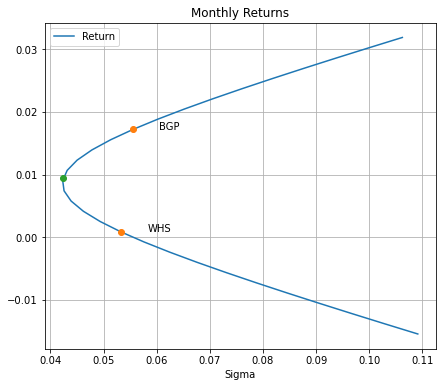

In [45]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set_title(r'Monthly Returns')
dfeff.plot(ax=ax, grid=True)
ax.plot(sigma.to_list(), mean_ret.to_list(), 'o') # assets
ax.plot(GMVP_sigma, GMVP_ret, 'o') # assets
# Labels
ax.text(sigma['BGP']+0.005,mean_ret['BGP'],'BGP')
ax.text(sigma['WHS']+0.005,mean_ret['WHS'],'WHS')
plt.show()

**Applying this to multiple pairs of stocks**

In [46]:
nzx_set, df_close = returns(nzx+['^NZ50'], '2011-10-01', '2022-04-30')

[*********************100%***********************]  152 of 152 completed

9 Failed downloads:
- NTLOB.NZ: No data found, symbol may be delisted
- FCT.NZ: No data found for this date range, symbol may be delisted
- AKL.NZ: No data found, symbol may be delisted
- MLNWE.NZ: No data found, symbol may be delisted
- PLP.NZ: No data found for this date range, symbol may be delisted
- JPG.NZ: No data found for this date range, symbol may be delisted
- CO2.NZ: No data found for this date range, symbol may be delisted
- KFLWG.NZ: No data found, symbol may be delisted
- BIF.NZ: No data found for this date range, symbol may be delisted


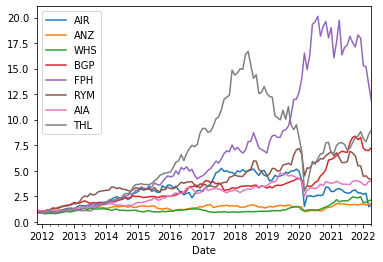

In [47]:
stocks_list = ["AIR", "ANZ", 'WHS', 'BGP', 'FPH', 'RYM', 'AIA', 'THL']  # tickers seperated by space
data = df_close[stocks_list]

# Calculate monthly returns
monthly_ret = np.log(data).diff().dropna()
monthly_ret.cumsum().apply(np.exp).plot()

mean_ret = monthly_ret.mean()
mean_ret.name = 'Mean Monthly Return'

In [48]:
monthly_ret.mean()

AIR    0.003978
ANZ    0.004433
WHS    0.006003
BGP    0.015740
FPH    0.019627
RYM    0.011274
AIA    0.010925
THL    0.017414
dtype: float64

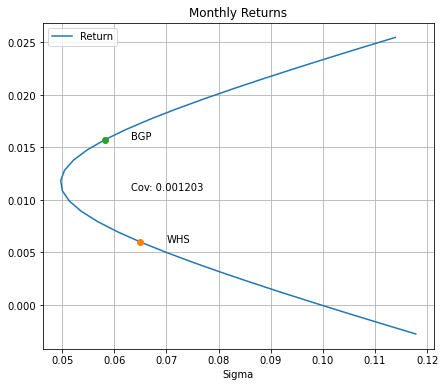

0.0012034063816049705

In [49]:
def demo_two_portfolios(monthly_ret, x, y):
    x_ret = monthly_ret[x].mean()
    y_ret = monthly_ret[y].mean()
    x_sig = monthly_ret[x].std()
    y_sig = monthly_ret[y].std()
    cov_mat  = monthly_ret.cov()
    
    x_var = cov_mat.loc[x][x]
    y_var = cov_mat.loc[y][y]
    
    x_y_cov = cov_mat.loc[y][x]

    x_weight = np.arange(-1,2,0.1)
    y_weight = 1-x_weight

    # Portfolio Z Mean Returns
    xy_ret = x_weight * x_ret + y_weight * y_ret
    #print(pd.Series(xy_ret))
        
    xy_sigma = (x_weight ** 2 * x_var + y_weight ** 2 * y_var + x_weight * y_weight * x_y_cov * 2) ** 0.5
        
    #print(pd.Series(xy_sigma))

    # Envelope
    dfeff = pd.DataFrame({'Sigma': xy_sigma, 'Return': xy_ret}, columns=['Sigma', 'Return'])
    dfeff.set_index('Sigma', inplace=True)
    dfeff.sample(5)

    fig, ax = plt.subplots(figsize=(7,6))
    ax.set_title(r'Monthly Returns')
    dfeff.plot(ax=ax, grid=True)
    ax.plot(x_sig, x_ret, 'o') # assets
    ax.plot(y_sig, y_ret, 'o') # assets
    
    # Labels
    ax.text(x_sig+0.005,x_ret,x)
    ax.text(y_sig+0.005,y_ret,y)
    ax.text(min(x_sig,y_sig)+0.005,(x_ret+y_ret)/2,'Cov: {:2.4}'.format(x_y_cov))
    plt.show()
    return x_y_cov
    
demo_two_portfolios(monthly_ret, 'WHS', 'BGP')

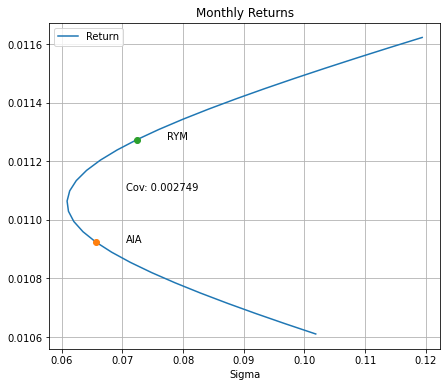

0.0027487699548534848

In [50]:
demo_two_portfolios(monthly_ret, 'AIA', 'RYM')

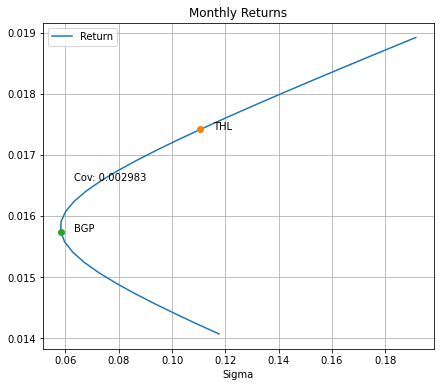

0.002983235375572467

In [51]:
demo_two_portfolios(monthly_ret, 'THL', 'BGP')